# Bayesian Binomial Regression 

This notebook is an introductory tutorial to Bayesian binomial regression with `RxInfer`.

In [1]:
using RxInfer, ReactiveMP, Random, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings

# Likelihood Specification

For observations $y_i$ with predictors $\mathbf{x}_i$, Binomial regression models the number of successes $y_i$ as a function of the predictors $\mathbf{x}_i$ and the regression coefficients $\boldsymbol{\beta}$

$$\begin{equation}
y_i \sim \text{Binomial}(n_i, p_i)\,,
\end{equation}$$

where:

$y_i$ is the number of successes, $n_i$ is the number of trials, $p_i$ is the probability of success. The probability $p_i$ is linked to the predictors through the logistic function:

$$\begin{equation}
p_i = \frac{1}{1 + e^{-\mathbf{x}_i^T\boldsymbol{\beta}}}
\end{equation}$$


# Prior Distributions
We specify priors for the regression coefficients:

$$\begin{equation}
\boldsymbol{\beta} \sim \mathcal{N}_{\xi}(\boldsymbol{\xi}, \boldsymbol{\Lambda})
\end{equation}$$

as a Normal distribution in precision-weighted mean form.



# Model Specification

The likelihood and the prior distributions form the probabilistic model

$$p(y, x, \beta, n) = p(\beta) \prod_{i=1}^N p(y_i \mid x_i, \beta, n_i),$$

where the goal is to infer the posterior distributions $p(\beta \mid y, x, n)$. Due to logistic link function, the posterior distribution is not conjugate to the prior distribution. This means that we need to use a more complex inference algorithm to infer the posterior distribution. Before dwelling into the details of the inference algorithm, let's first generate some synthetic data to work with.

In [2]:
function generate_synthetic_binomial_data(
    n_samples::Int,
    true_beta::Vector{Float64};
    seed::Int=42
)
    n_features = length(true_beta)
    rng = StableRNG(seed)
    
    X = randn(rng, n_samples, n_features)
    
    n_trials = rand(rng, 5:20, n_samples)
    
    logits = X * true_beta
    probs = 1 ./ (1 .+ exp.(-logits))
    
    y = [rand(rng, Binomial(n_trials[i], probs[i])) for i in 1:n_samples]
    
    return X, y, n_trials, probs
end


n_samples = 10000
true_beta =  [-3.0 , 2.6]

X, y, n_trials,probs = generate_synthetic_binomial_data(n_samples, true_beta);
X = [collect(row) for row in eachrow(X)];


We generate `X` as the design matrix and `y` as the number of successes and `n_trials` as the number of trials. Next task is to define the graphical model. RxInfer provides a `BinomialPolya` factor node that is a combination of a Binomial distribution and a PolyaGamma distribution introduced in [1]. The `BinomialPolya` factor node is used to model the likelihood of the binomial distribution. 

Due to non-conjugacy of the likelihood and the prior distribution, we need to use a more complex inference algorithm. RxInfer provides an Expectation Propagation (EP) [2] algorithm to infer the posterior distribution. Due to EP's approximation, we need to specify an inbound message for the regression coefficients while using the `BinomialPolya` factor node. This feature is implemented in the `dependencies` keyword argument during the creation of the `BinomialPolya` factor node. `ReactiveMP.jl` provides a `RequireMessageFunctionalDependencies` type that is used to specify the inbound message for the regression coefficients `β`. Refer to the ReactiveMP.jl documentation for more information.

In [3]:
@model function binomial_model(prior_xi, prior_precision, n_trials, X, y) 
    β ~ MvNormalWeightedMeanPrecision(prior_xi, prior_precision)
    for i in eachindex(y)
        y[i] ~ BinomialPolya(X[i], n_trials[i], β) where {
            dependencies = RequireMessageFunctionalDependencies(β = MvNormalWeightedMeanPrecision(prior_xi, prior_precision))
        }
    end
end

  This example uses the precision-weighted mean parametrization (`MvNormalWeightedMeanPrecision`) of the Gaussian distribution for efficiency reasons. While this is less conventional than the standard mean-covariance form, the example would work equally well with any parametrization. The choice of parametrization mainly affects computational efficiency and numerical stability, not the underlying model or results.

Having specified the model, we can now utilize the `infer` function to infer the posterior distribution.

In [4]:
n_features = length(true_beta)
results = infer(
    model = binomial_model(prior_xi = zeros(n_features), prior_precision = diageye(n_features),),
    data = (X=X, y=y,n_trials=n_trials),
    iterations = 30,
    free_energy = true,
    showprogress = true,
    options = (
        limit_stack_depth = 100, # to prevent stack-overflow errors
    )
)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (β)
  Free Energy:     | Real[21992.9, 16235.8, 13785.0, 12519.7, 11800.1, 11366.2, 11094.1, 10918.7, 10803.3, 10726.3  …  10561.6, 10560.6, 10559.9, 10559.4, 10559.0, 10558.8, 10558.6, 10558.5, 10558.4, 10558.3]


We can now plot the free energy to see if the inference algorithm is converging.

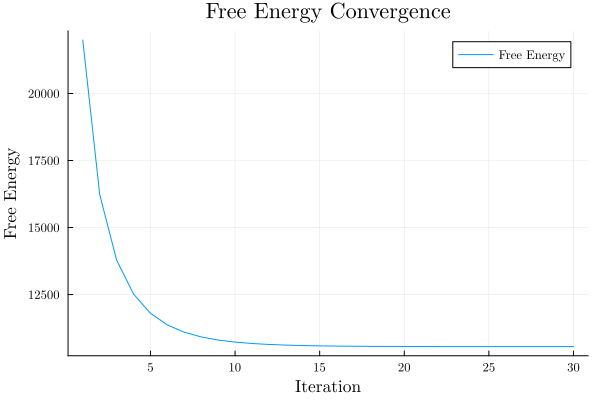

In [5]:
plot(results.free_energy,fontfamily = "Computer Modern", label="Free Energy", xlabel="Iteration", ylabel="Free Energy", title="Free Energy Convergence")

Free energy is converging to a stable value, indicating that the inference algorithm is converging. Let's visualize the posterior distribution and how it compares to the true parameters.

┌ Info: Saved animation to /Users/bvdmitri/.julia/dev/RxInferExamples.jl/examples/Basic Examples/Bayesian Binomial Regression/bayesian_regression_posterior.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/3u4B6/src/animation.jl:156


Plots.AnimatedGif("/Users/bvdmitri/.julia/dev/RxInferExamples.jl/examples/Basic Examples/Bayesian Binomial Regression/bayesian_regression_posterior.gif")
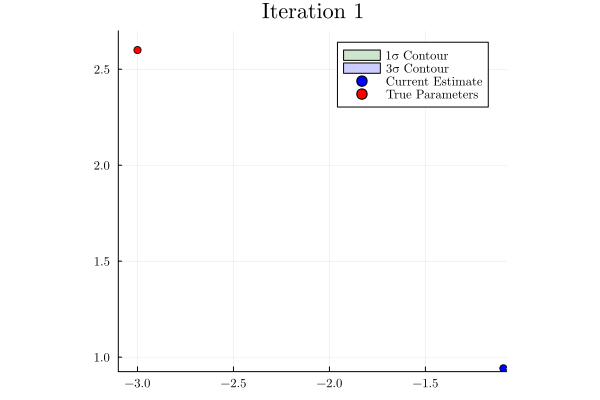

In [6]:
# Create an animation showing how posterior evolves
anim = @animate for i in 1:length(results.posteriors[:β])
    # Get posterior at current iteration
    m_i = mean(results.posteriors[:β][i])
    Σ_i = cov(results.posteriors[:β][i])
    
    # Calculate dynamic limits based on current mean and covariance
    # Add some padding (3 standard deviations) to ensure true parameters are visible
    x_std = sqrt(Σ_i[1,1])
    y_std = sqrt(Σ_i[2,2])
    
    x_min = min(m_i[1] - 3*x_std, true_beta[1] - 0.1)
    x_max = max(m_i[1] + 3*x_std, true_beta[1] + 0.1)
    y_min = min(m_i[2] - 3*y_std, true_beta[2] - 0.1)
    y_max = max(m_i[2] + 3*y_std, true_beta[2] + 0.1)
    
    p = plot(xlims=(x_min, x_max), ylims=(y_min, y_max),
             fontfamily = "Computer Modern",
             title="Iteration $i", aspect_ratio=1)
    
    # Plot confidence ellipses
    covellipse!(m_i, Σ_i, n_std=1, label="1σ Contour", color=:green, fillalpha=0.2)
    covellipse!(m_i, Σ_i, n_std=3, label="3σ Contour", color=:blue, fillalpha=0.2)
    
    # Plot mean estimate and true parameters
    scatter!([m_i[1]], [m_i[2]], label="Current Estimate", color=:blue)
    scatter!([true_beta[1]], [true_beta[2]], label="True Parameters", color=:red)
end

# Save the animation as a GIF
gif(anim, "bayesian_regression_posterior.gif", fps=3)

![](bayesian_regression_posterior.gif)

We can perform prediction by augmenting the data with missing values. For that, we can create a new vector `y_with_missing` that contains missing values for the last 2000 samples.

In [7]:
y_with_missing = Vector{Union{Missing, Int}}(missing, n_samples)
for i in 1:n_samples
    if i > 8000
        y_with_missing[i] = missing
    else
        y_with_missing[i] = y[i]
    end
end

In [8]:
results_with_missing = infer(
    model = binomial_model(prior_xi = zeros(n_features), prior_precision = diageye(n_features),),
    data = (X=X, y=y_with_missing,n_trials=n_trials),
    iterations = 30,
    showprogress = true,
    options = (
        limit_stack_depth = 100, # to prevent stack-overflow errors
    )
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
  Posteriors       | available for (β)
  Predictions      | available for (y)


In [9]:
probs_prediction = map(d -> d.p,results_with_missing.predictions[:y][end][8000:end])
err = probs_prediction .- probs[8000:end]
mse = mean(err.^2)
println("Mean squared error: ", mse)

Mean squared error: 3.5418461838003327e-6


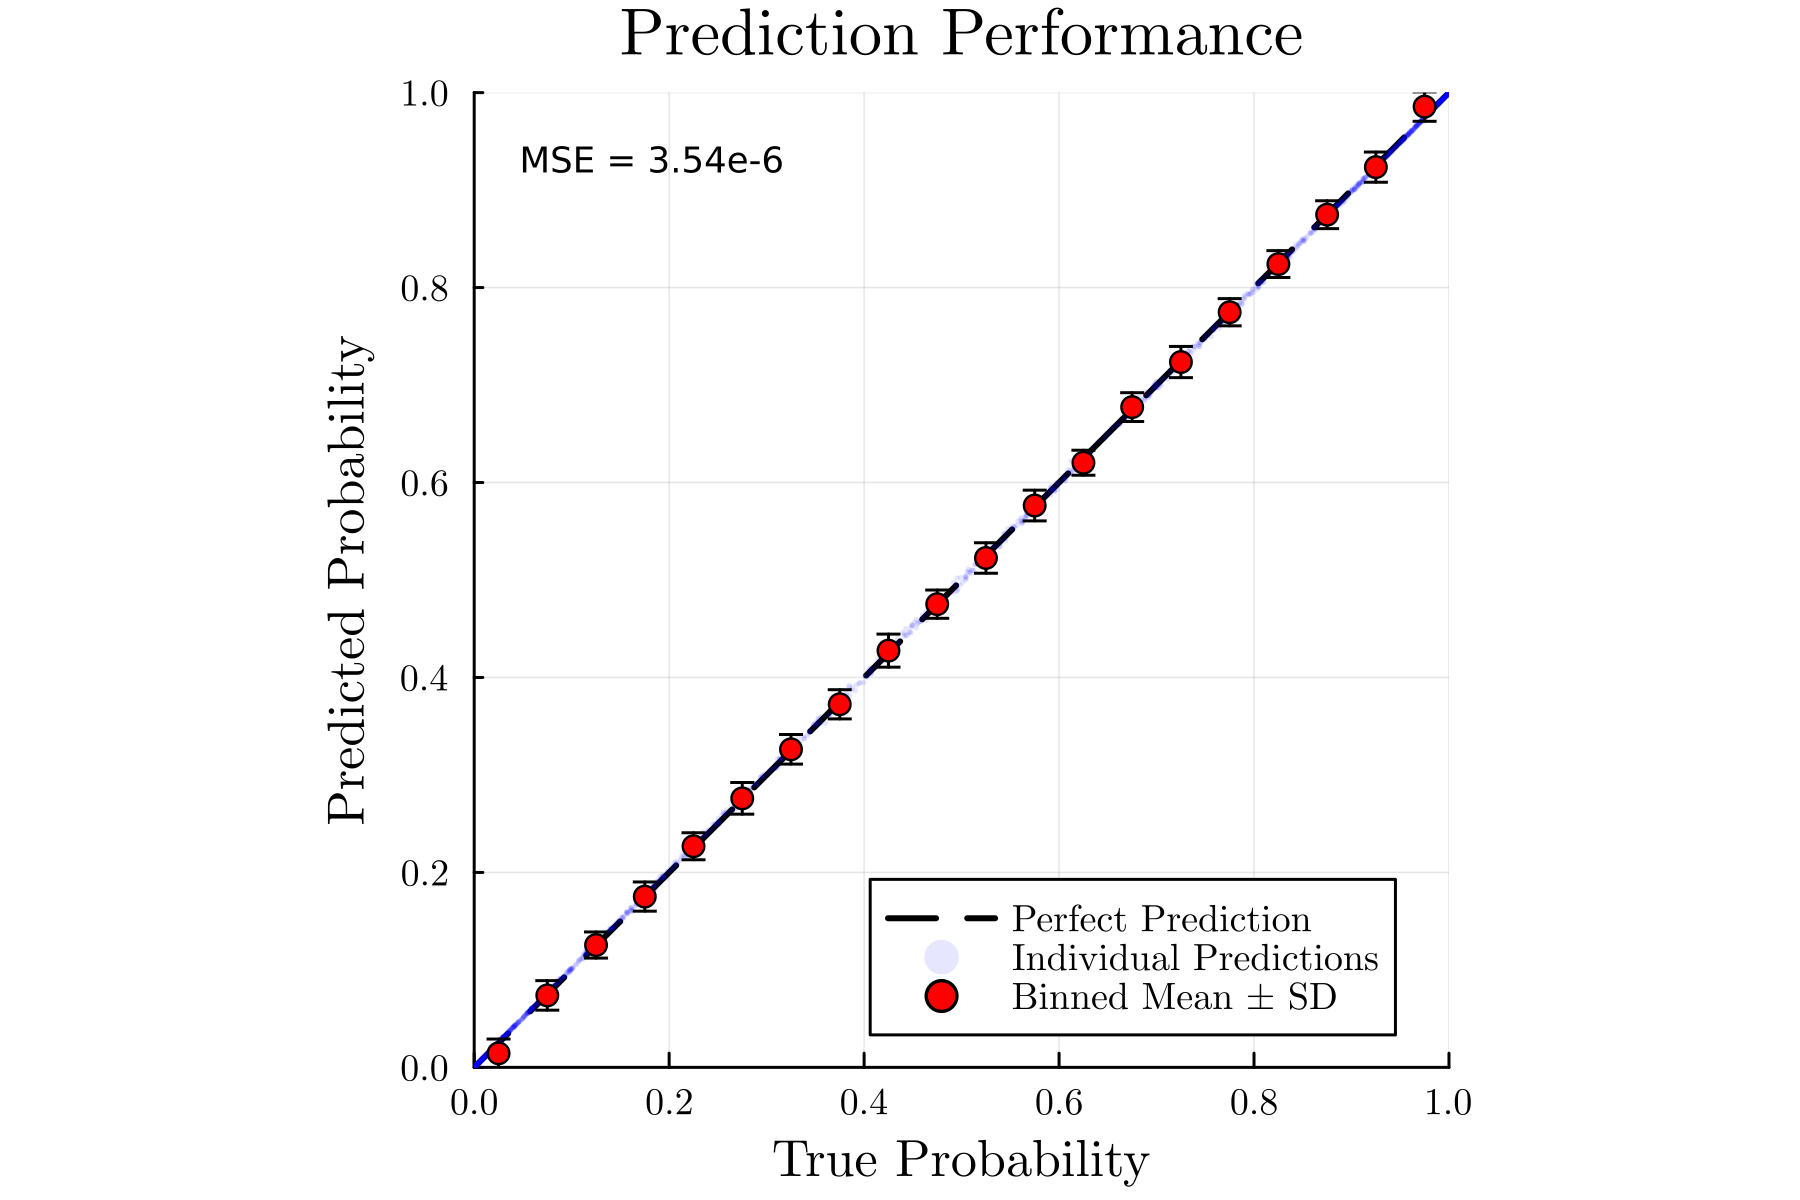

In [10]:
function bin_predictions(true_probs, pred_probs; n_bins=20)
    bins = range(0, 1, length=n_bins+1)
    bin_means = Float64[]
    bin_stds = Float64[]
    bin_centers = Float64[]
    
    for i in 1:n_bins
        mask = (true_probs .>= bins[i]) .& (true_probs .< bins[i+1])
        if any(mask)
            push!(bin_means, mean(pred_probs[mask]))
            push!(bin_stds, std(pred_probs[mask]))
            push!(bin_centers, (bins[i] + bins[i+1])/2)
        end
    end
    return bin_centers, bin_means, bin_stds
end

# Create the plot
bin_centers, bin_means, bin_stds = bin_predictions(probs[8000:end], probs_prediction)

p = plot(
    xlabel = "True Probability",
    ylabel = "Predicted Probability",
    title = "Prediction Performance",
    aspect_ratio = 1,
    legend = :bottomright,
    grid = true,
    fontfamily = "Computer Modern",
    dpi = 300
)

# Add perfect prediction line
plot!([0, 1], [0, 1], 
    label = "Perfect Prediction", 
    color = :black, 
    linestyle = :dash,
    linewidth = 2
)

# Add scatter plot with reduced opacity and size
scatter!(
    probs[8000:end], 
    probs_prediction,
    label = "Individual Predictions",
    alpha = 0.1,  # Reduced opacity
    color = :blue,
    markersize = 1,
    markerstrokewidth = 0
)

# Add binned means with error bars
scatter!(
    bin_centers,
    bin_means,
    yerror = bin_stds,
    label = "Binned Mean ± SD",
    color = :red,
    markersize = 4
)

annotate!(
    0.05, 
    0.95, 
    text("MSE = $(round(mse, digits=8))", 8, :left, :top)
)

# Customize axes
plot!(
    xlims = (0,1),
    ylims = (0,1),
    xticks = 0:0.2:1,
    yticks = 0:0.2:1
)

# References
[1] Polson, N. G., Scott, J. G., & Windle, J. (2013). Bayesian inference for logistic models using Polya-Gamma latent variables. *Journal of the American Statistical Association*, 108(1), 136-146.

[2] Minka, T. (2001). Expectation Propagation for approximate Bayesian inference. *Uncertainty in Artificial Intelligence*, 2, 362-369.